In [69]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import statsmodels.api as sm
from scipy.signal.windows import hann
import scipy.io
from scipy.io import loadmat
from mne.filter import filter_data

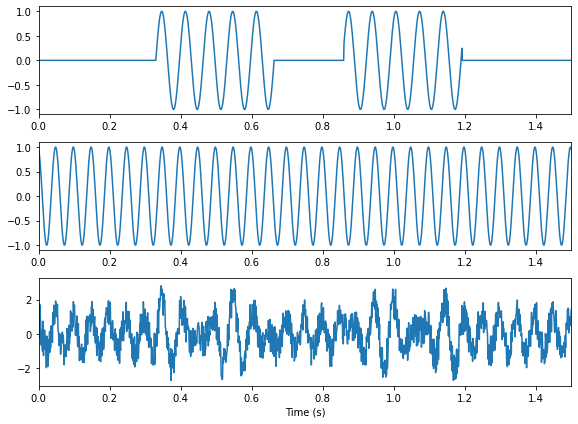

In [101]:
## Simulated signal
# Generate a simulated signal with 3 bursts at 15Hz with 5 cycles
# and an oscillation at 20Hz, plus white noise

np.random.seed(42)

# Time step (s)
dt=.001
# Duration (s)
T=5
# Time vector
time=np.linspace(0,T,int(T/dt))
# Sampling rate
srate=1/dt

# Burst frequency
f1 = 15
# Length of bursts in cycles
f1_num_cycles=5
# Number of bursts
f1_num_bursts=5

# Oscillation frequency
f2 = 20

# Burst signal
s1=np.zeros((len(time)))

# Keep track of burst start and stop times so they
# don't overlap
burst_starts=[]
burst_stops=[]

# Burst duration in seconds
dur_s=f1_num_cycles/f1
# Burst duration in time steps
dur_pts=int(dur_s/dt)

# Random start and stop time
start=int(0.33/dt)
stop=start+dur_pts
s1[start:stop]=np.sin(2. * np.pi * f1 * (time[start:stop]-time[start]))
burst_starts.append(start)
burst_stops.append(stop)
    
while len(burst_starts)<f1_num_bursts:
    # Random start and stop time
    start=np.random.randint(int(T/dt)-dur_pts)
    stop=start+dur_pts
    
    # Check that doesn't overlap with other bursts
    overlap=False
    for (other_start,other_stop) in zip(burst_starts,burst_stops):
        if (start >= other_start and start < other_stop) or (stop > other_start and stop <= other_stop):
            overlap=True
            break
          
    # Generate burst
    if not overlap:
        s1[start:stop]=np.sin(2. * np.pi * f1 * (time[start:stop]+np.random.randn()))
        burst_starts.append(start)
        burst_stops.append(stop)

# Oscillatory signal
s2=np.sin(2. * np.pi * f2 * (time-time[start]))

# Generated signal
signal=s1+s2+np.random.uniform(-1,1,len(time))

plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.plot(time,s1)
plt.xlim([0.0,1.5])
plt.subplot(3,1,2)
plt.plot(time,s2)
plt.xlim([0.0,1.5])
plt.subplot(3,1,3)
plt.plot(time,signal)
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.tight_layout()

/home/bonaiuto/miniconda3/envs/new_lc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


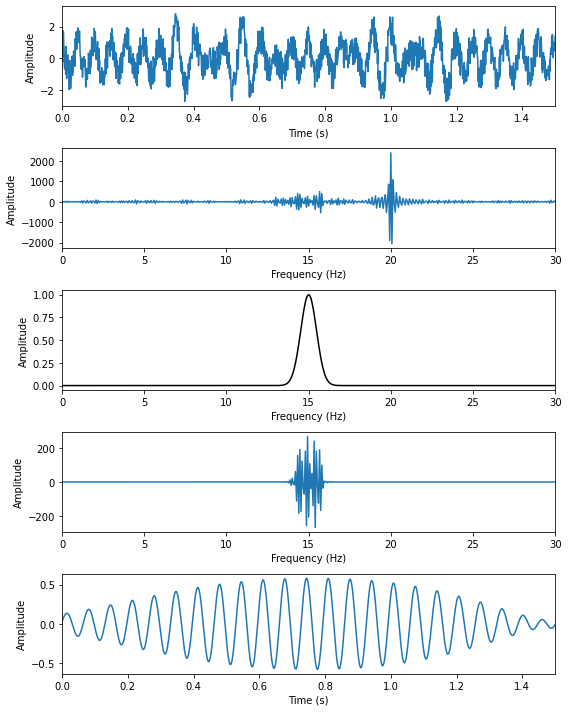

In [115]:
## Laggged Hilbert coherence
# Lagged Hilbert coherence starts with bandpass filtering using
# multiplication by a Gaussian kernel in the frequency domain

# Frequencies to evaluate (just to compute desired frequency
# resolution in this step)
freqs=np.linspace(5,100,100)

# Determine the frequency resolution
df = np.diff(freqs)[0]

# Zero-pad the signal
pad=np.zeros((len(time)))
padd_signal = np.hstack([pad, signal, pad])

# Fourier transform the padded signal
signal_fft = np.fft.rfft(padd_signal, axis=-1)    
fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1/srate)

# Kernel width for multiplication
sigma = df * .5

# Center pass-band frequency
freq=15

# Gaussian kernel centered on frequency with width defined
# by requested frequency resolution
kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

# Multiply Fourier-transformed signal by kernel
fsignal_fft = np.multiply(signal_fft, kernel)
# Reverse Fourier to get bandpass filtered signal
f_signal = np.fft.irfft(fsignal_fft, axis=-1)

plt.figure(figsize=(8,10))
plt.subplot(5,1,1)
plt.plot(time,signal)
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(5,1,2)
plt.plot(fft_frex,signal_fft)
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,3)
plt.plot(fft_frex,kernel,'k')
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,4)
plt.plot(fft_frex,fsignal_fft)
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,5)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()

plt.savefig('bp_filtering.svg')

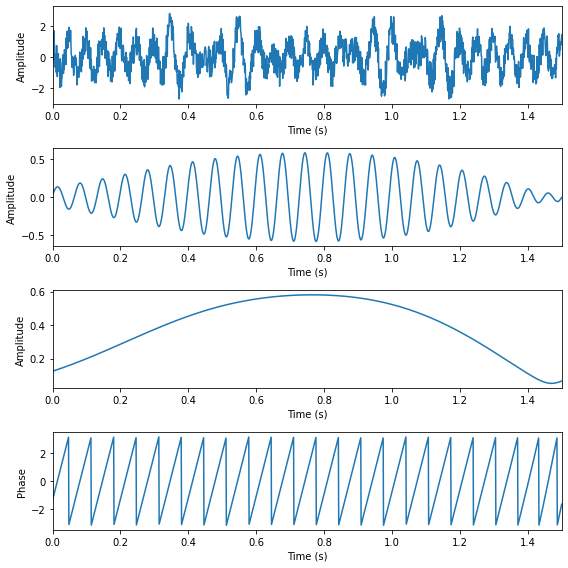

In [103]:
# Get analytic signal of bandpass filtered data (phase and amplitude)
analytic_signal = hilbert(f_signal, N=None, axis=-1)
# Cut off padding
analytic_signal=analytic_signal[len(time):2 * len(time)]

plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Phase')


plt.tight_layout()

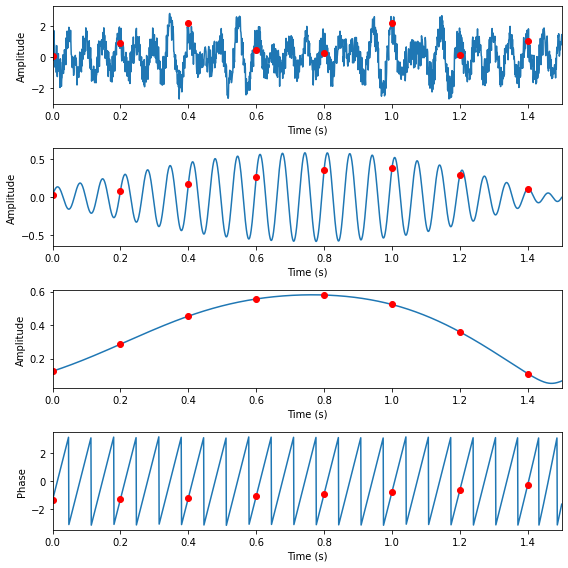

In [104]:
# Evaluate lagged coherence at a lag of 3 cycles
lag=3

# Duration of this lag in s
lag_dur_s = lag / freq
# Number of evaluations
n_evals = int(np.floor(T / lag_dur_s))
# Remaining time
diff = T - (n_evals * lag_dur_s)

# Start time
start_time = time[0]
# Evaluation times (ms)
eval_times = np.linspace(start_time, T, n_evals + 1)[:-1]
# Evaluation time points
eval_pts = np.searchsorted(time, eval_times)


plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.plot(eval_times,signal[eval_pts],'ro')
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.plot(eval_times,f_signal[len(time)+eval_pts],'ro')
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.plot(eval_times,np.abs(analytic_signal[eval_pts]),'ro')
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.plot(eval_times,np.angle(analytic_signal[eval_pts]),'ro')
plt.xlim([0.0,1.5])
plt.xlabel('Time (s)')
plt.ylabel('Phase')

plt.tight_layout()

In [105]:
# Putting it all together
def lagged_hilbert_coherence(signal, srate, freq, lag, df):
    
    n_pts = len(signal)
    T = n_pts * 1 / srate
    time = np.linspace(0, T, int(T * srate))
    
    # Bandpass filtering using multiplication by a Gaussian kernel
    # in the frequency domain

    # Zero-pad the signal
    pad=np.zeros((len(signal)))
    padd_signal = np.hstack([pad, signal, pad])

    # Fourier transform the padded signal
    signal_fft = np.fft.rfft(padd_signal, axis=-1)    
    fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1/srate)

    # Kernel width for multiplication
    sigma = df * .5

    # Gaussian kernel centered on frequency with width defined
    # by requested frequency resolution
    kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

    # Multiply Fourier-transformed signal by kernel
    fsignal_fft = np.multiply(signal_fft, kernel)
    # Reverse Fourier to get bandpass filtered signal
    f_signal = np.fft.irfft(fsignal_fft, axis=-1)
    
    # Get analytic signal of bandpass filtered data (phase and amplitude)
    analytic_signal = hilbert(f_signal, N=None, axis=-1)
    # Cut off padding
    analytic_signal=analytic_signal[len(time):2 * len(time)]
    
    # Duration of this lag in s
    lag_dur_s = lag / freq
    # Number of evaluations
    n_evals = int(np.floor(T / lag_dur_s))
    # Remaining time
    diff = T - (n_evals * lag_dur_s)

    # Start time
    start_time = time[0]
    # Evaluation times (ms)
    eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
    # Evaluation time points
    eval_pts = np.searchsorted(time, eval_times)
    
    # Number of points between the first and next evaluation time points
    n_range = eval_pts[1] - eval_pts[0]
    # Analytic signal at n=0...n_evals-1 evaluation points, and m=0..n_range time points in between
    f1 = analytic_signal[eval_pts[:-1,np.newaxis]+ np.arange(n_range)]
    # Analytic signal at n=1...n_evals evaluation points, and m=0..n_range time points in between
    f2 = analytic_signal[eval_pts[1:,np.newaxis]+ np.arange(n_range)]

    # Calculate the phase difference and amplitude product
    phase_diff = np.angle(f2) - np.angle(f1)
    amp_prod = np.abs(f1) * np.abs(f2)

    # Lagged coherence
    expected_phase_diff = lag * 2 * math.pi
    num = np.sum(amp_prod * np.exp(complex(0, 1) * (expected_phase_diff - phase_diff)),axis=0)
    f1_pow = np.power(f1, 2)
    f2_pow = np.power(f2, 2)
    denom = np.sqrt(np.sum(np.abs(f1_pow),axis=0) * np.sum(np.abs(f2_pow),axis=0))
    lc = np.abs(num / denom)

    # Average over the time points in between evaluation points
    lc = np.mean(lc)

    return num, denom, lc

/tmp/ipykernel_106100/2925102537.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  num[f_idx,l_idx]=np.mean(n)


Text(0, 0.5, 'Frequency (Hz)')

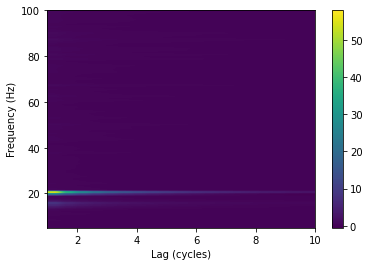

In [106]:
# At 40Hz, the numerator and denominator are both low, but nearly exactly the same
# This is due to amplitude correlations introduced by bandpass filtering in a freq
# range with low power (https://journals.physiology.org/doi/full/10.1152/jn.00851.2013)
# Here's the effect over a range of frequencies

# Evaluate at 2-10 lag cycles
lags=np.arange(1,10.5,.5)
# Evaluate at 5-100 Hz
freqs=np.linspace(5,100,100)
# Determine the frequency resolution
df = np.diff(freqs)[0]

num=np.zeros((len(freqs),len(lags)))
denom=np.zeros((len(freqs),len(lags)))
lcs=np.zeros((len(freqs),len(lags)))
for f_idx,freq in enumerate(freqs):    
    for l_idx,lag in enumerate(lags):
        n, d, lcs[f_idx,l_idx] = lagged_hilbert_coherence(signal, srate, freq, lag, df)
        num[f_idx,l_idx]=np.mean(n)
        denom[f_idx,l_idx]=np.mean(d)
        
im=plt.imshow(num, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto')
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

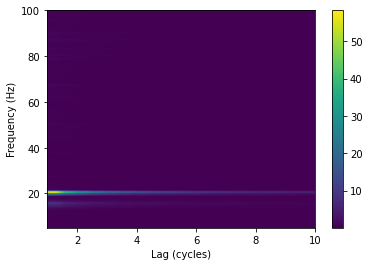

In [107]:
im=plt.imshow(denom, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto')
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

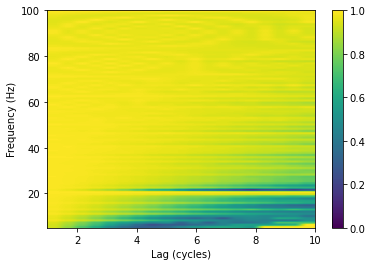

In [108]:
im=plt.imshow(lcs, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

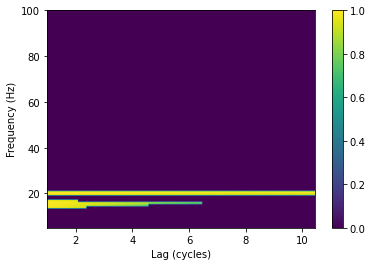

In [109]:
# The solution is to use the amplitude covariance of a surrogate 
# dataset as a threshold. We use an ARMA model to account for
# aperiodic temporal structure

def ar_surr(signal, k_perm):
    n_pts=len(signal)
    
    # Estimate an AR model
    mdl_order = (1, 0, 0)
    mdl = sm.tsa.ARIMA(signal, order=mdl_order)
    result = mdl.fit()
    # Make a generative model using the ARMA parameters
    arma_process = sm.tsa.ArmaProcess.from_estimation(result)
    # Simulate a bunch of time-courses from the model
    x_sim = arma_process.generate_sample((k_perm,signal.shape[-1]),
                                         scale=result.resid.std(), axis=1)    
    pad = np.zeros(x_sim.shape)
    
    padd_rand_signal = np.hstack([pad, x_sim, pad])

    # Get analytic signal (phase and amplitude)
    analytic_rand_signal = hilbert(padd_rand_signal, N=None, axis=-1)[:,n_pts:2 * n_pts]

    # Analytic signal at n=0...-1
    f1 = analytic_rand_signal[:,0:-1]
    # Analytic signal at n=1,...
    f2 = analytic_rand_signal[:,1:]

    amp_prod = np.abs(f1) * np.abs(f2)
    amp_prods=np.mean(amp_prod,axis=-1)
    return amp_prods

def lagged_hilbert_coherence_thresh(signal, srate, freqs, lags, df):
    
    n_pts = len(signal)
    T = n_pts * 1 / srate
    time = np.linspace(0, T, int(T * srate))
    
    filtered_signal = filter_data(signal, srate, freqs[0], freqs[-1], verbose=False)
    
    n_shuffles=1000
    amp_prods=ar_surr(filtered_signal, n_shuffles)
    threshold=np.percentile(amp_prods,5)

    # Bandpass filtering using multiplication by a Gaussian kernel
    # in the frequency domain

    # Zero-pad the signal
    pad=np.zeros((len(signal)))
    padd_signal = np.hstack([pad, signal, pad])

    # Fourier transform the padded signal
    signal_fft = np.fft.rfft(padd_signal, axis=-1)    
    fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1/srate)

    # Kernel width for multiplication
    sigma = df * .5

    lcs=np.zeros((len(freqs),len(lags)))
    all_denoms=[]
    for f_idx, freq in enumerate(freqs):
        # Gaussian kernel centered on frequency with width defined
        # by requested frequency resolution
        kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

        # Multiply Fourier-transformed signal by kernel
        fsignal_fft = np.multiply(signal_fft, kernel)
        # Reverse Fourier to get bandpass filtered signal
        f_signal = np.fft.irfft(fsignal_fft, axis=-1)

        # Get analytic signal of bandpass filtered data (phase and amplitude)
        analytic_signal = hilbert(f_signal, N=None, axis=-1)
        # Cut off padding
        analytic_signal=analytic_signal[len(time):2 * len(time)]

        for l_idx, lag in enumerate(lags):
            # Duration of this lag in s
            lag_dur_s = lag / freq
            # Number of evaluations
            n_evals = int(np.floor(T / lag_dur_s))
            # Remaining time
            diff = T - (n_evals * lag_dur_s)

            # Start time
            start_time = time[0]
            # Evaluation times (ms)
            eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
            # Evaluation time points
            eval_pts = np.searchsorted(time, eval_times)

            # Number of points between the first and next evaluation time points
            n_range = eval_pts[1] - eval_pts[0]
            # Analytic signal at n=0...n_evals-1 evaluation points, and m=0..n_range time points in between
            f1 = analytic_signal[eval_pts[:-1,np.newaxis]+ np.arange(n_range)]
            # Analytic signal at n=1...n_evals evaluation points, and m=0..n_range time points in between
            f2 = analytic_signal[eval_pts[1:,np.newaxis]+ np.arange(n_range)]

            # Calculate the phase difference and amplitude product
            phase_diff = np.angle(f2) - np.angle(f1)
            amp_prod = np.abs(f1) * np.abs(f2)

            # Lagged coherence
            expected_phase_diff = lag * 2 * math.pi
            num = np.sum(amp_prod * np.exp(complex(0, 1) * (expected_phase_diff-phase_diff)),axis=0)
            f1_pow = np.power(f1, 2)
            f2_pow = np.power(f2, 2)
            denom = np.sqrt(np.sum(np.abs(f1_pow),axis=0) * np.sum(np.abs(f2_pow),axis=0))
            lc = np.abs(num / denom)
            lc[denom<threshold]=0
            # Average over the time points in between evaluation points
            lcs[f_idx,l_idx] = np.mean(lc)
            all_denoms.append(denom)
    return lcs, all_denoms

# Evaluate at 2-10 lag cycles
lags=np.arange(1,10.5,.05)
# Evaluate at 5-100 Hz
freqs=np.linspace(5,100,100)
# Determine the frequency resolution
df = np.diff(freqs)[0]

lcs, denoms=lagged_hilbert_coherence_thresh(signal, srate, freqs, lags, df)
        
im=plt.imshow(lcs, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1, interpolation=None)
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

In [110]:
filtered_signal = filter_data(signal, srate, freqs[0], freqs[-1], verbose=False)
k_perm=10000
n_pts=len(signal)

In [111]:
# Estimate an ARMA model
mdl = sm.tsa.ARIMA(filtered_signal, order=(1, 0, 1))
result = mdl.fit()
# Make a generative model using the ARMA parameters
arma_process = sm.tsa.ArmaProcess.from_estimation(result)
# Simulate a bunch of time-courses from the model
x_sim = arma_process.generate_sample((k_perm,signal.shape[-1]),
                                     scale=result.resid.std(), axis=1)    
pad = np.zeros(x_sim.shape)

padd_rand_signal = np.hstack([pad, x_sim, pad])

# Get analytic signal (phase and amplitude)
analytic_rand_signal = hilbert(padd_rand_signal, N=None, axis=-1)[:,n_pts:2 * n_pts]

# Analytic signal at n=0...-1
f1 = analytic_rand_signal[:,0:-1]
# Analytic signal at n=1,...
f2 = analytic_rand_signal[:,1:]

amp_prod = np.abs(f1) * np.abs(f2)
amp_prods_arma_filt=np.mean(amp_prod,axis=-1)

/home/bonaiuto/miniconda3/envs/new_lc/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


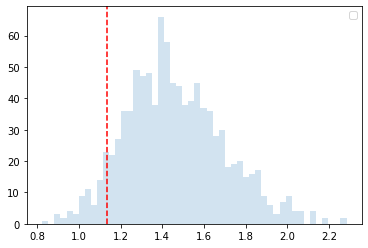

In [116]:
plt.hist(amp_prods_ar_filt,50,alpha=.2)
yl=plt.ylim()
thresh=np.percentile(amp_prods_arma_filt,5)
plt.plot([thresh, thresh], yl, 'r--')
plt.ylim(yl)
plt.legend()
plt.savefig('ar_amp_prod_dist.svg')